In [1]:
import os
import logging
from typing import List, Optional
import wandb

import pandas as pd

import torch

from nll_to_po.models.dn_policy import MLPPolicy, MLPPolicy_Full_Cov
from nll_to_po.training.utils import train_single_policy, setup_logger
import nll_to_po.training.loss as L
import nll_to_po.training.reward as R

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB output

<Figure size 640x480 with 0 Axes>

### config

In [2]:
mean = torch.zeros(2)
l= torch.tensor([[1.0, 0.0],
                  [0.5, 0.2]])  

dist = torch.distributions.MultivariateNormal(mean, scale_tril=l)

print("covariance:\n", dist.covariance_matrix)

covariance:
 tensor([[1.0000, 0.5000],
        [0.5000, 0.2900]])


In [3]:
torch.eye(3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [4]:
df_list: list[pd.DataFrame] = []

In [5]:
def rand_sigma_tensor(output_dim):
    "renvoie une matrice de covariance aléatoire de taille output_dim fois output_dim"
    shape=(output_dim,output_dim)
    A=torch.rand(shape)
    matrix=A@A.T
    return matrix

In [6]:
def random_spd_matrix(output_dim: int, beta: float, device="cpu", seed=4):
    torch.manual_seed(seed) #fixe
    A = torch.randn(output_dim, output_dim, device=device)
    M = A @ A.T  

    U = beta * M
    return U


In [7]:
import numpy as np

In [8]:
import random 
list_of_tensor=[]
for k in range(3):
    N=random_spd_matrix(2,1)
    print(N)


tensor([[ 2.6310, -3.3986],
        [-3.3986,  5.7349]])
tensor([[ 2.6310, -3.3986],
        [-3.3986,  5.7349]])
tensor([[ 2.6310, -3.3986],
        [-3.3986,  5.7349]])


In [9]:
seed=random.randint(1,100)
print(seed)

94


EXP avec beta etoile d'apres les calculs 

In [10]:
import torch
from torch.distributions import MultivariateNormal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

output_dim = 2

# RL/PO params
n_generations = 50
use_rsample = False
reward_transform = "normalize"
entropy_weight = 0.001
# training params
n_experiments = 150
n_updates = 100
learning_rate = 7*1e-4
input_dim = 10
number_of_hidden_layers=2
hidden_sizes = [32]*number_of_hidden_layers
fixed_logstd = False # Pour que le NN apprennne aussi la matrice de covariance 

df_list = []
seed=random.randint(1,100) #je choisi une seed diff pour générer la matrice de F_lambda,Sigma
for exp_idx in range(n_experiments):
    torch.manual_seed(1234 + exp_idx)

    mu = torch.ones(output_dim)
    Sigma=rand_sigma_tensor(output_dim=output_dim)
   
    q = MultivariateNormal(mu, covariance_matrix=Sigma)

    N = 64
    y = q.sample((N,))                          # (N,2)
    X = torch.randn(1, input_dim).repeat(N, 1)  # X constant (jouet)
    batch_size = N

    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    policy = MLPPolicy_Full_Cov(input_dim, output_dim, hidden_sizes)

    loss_nll = L.NLL_Full_Cov(target_mu=mu, 
        target_sigma=Sigma)
    _, nll_metrics, _ = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        loss_function=loss_nll,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=None,
        tensorboard_writer=None,
        logger=None,
    )

    df = pd.DataFrame(nll_metrics).reset_index().rename(columns={"index": "epoch"})
    df["method"] = "NLL"
    df["beta"] = None
    df["is_special"] = False
    df["experiment"] = exp_idx
    # log mu, Sigma (scalaires)
    df["mu_0"] = float(mu[0]); df["mu_1"] = float(mu[1])
    df["Sigma_00"] = float(Sigma[0,0]); df["Sigma_01"] = float(Sigma[0,1])
    df["Sigma_10"] = float(Sigma[1,0]); df["Sigma_11"] = float(Sigma[1,1])
    df["entropy_weight"] = entropy_weight
    df_list.append(df)

    #Policy Gradient avec le U etoile trouve en closed form 
    Sigma_trace = float(torch.trace(Sigma))
    beta_star = float(entropy_weight * (output_dim) / Sigma_trace)  # U* dans F_lambda,Sigma
    betas = [1,beta_star]

    for beta in betas:
        policy = MLPPolicy_Full_Cov(input_dim, output_dim, hidden_sizes)

        U= random_spd_matrix(output_dim=output_dim, beta=beta)
        reward_fn = R.Mahalanobis(matrix=U)

        loss_po = L.PO_Entropy_Full_Cov(
            reward_fn=reward_fn,
            n_generations=n_generations,
            use_rsample=use_rsample,
            reward_transform=reward_transform,
            entropy_weight=entropy_weight,
            target_mu=mu, 
        target_sigma=Sigma,
        )

        _, po_metrics, _ = train_single_policy(
            policy=policy,
            train_dataloader=train_dataloader,
            loss_function=loss_po,
            n_updates=n_updates,
            learning_rate=learning_rate,
            wandb_run=None,
            tensorboard_writer=None,
            logger=None,
        )

        df = pd.DataFrame(po_metrics).reset_index().rename(columns={"index": "epoch"})
        df["method"] = "Policy_Gradient_Entropy"
        df["beta"] = beta
        df["is_special"] = abs(beta - beta_star) < 1e-12
        df["experiment"] = exp_idx
        df["mu_0"] = float(mu[0]); df["mu_1"] = float(mu[1])
        df["Sigma_00"] = float(Sigma[0,0]); df["Sigma_01"] = float(Sigma[0,1])
        df["Sigma_10"] = float(Sigma[1,0]); df["Sigma_11"] = float(Sigma[1,1])
        df["entropy_weight"] = entropy_weight
        df_list.append(df)



Training epochs: 100%|██████████| 100/100 [00:00<00:00, 683.98it/s]


/var/folders/s5/t7mmwbn97js0q3cx70zrm69c0000gp/T/ipykernel_59928/3752024370.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all=pd.concat(df_list, ignore_index=True)


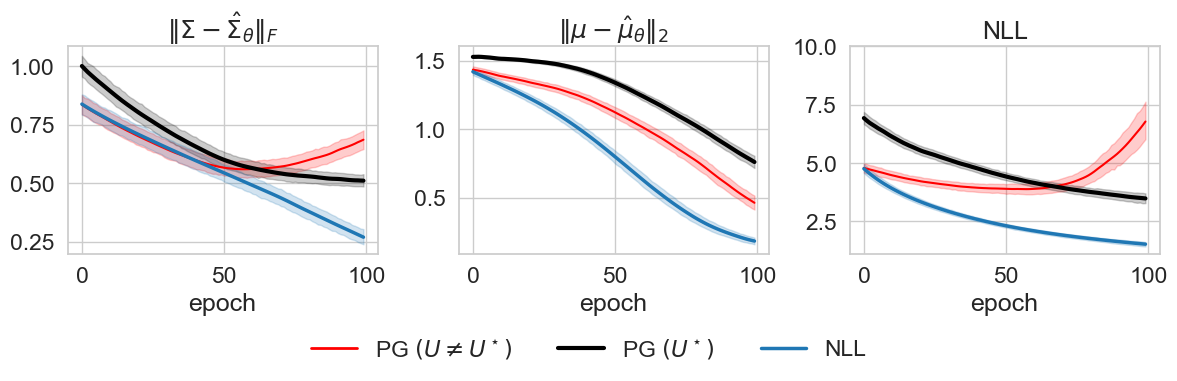

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sns.set_style("whitegrid")
df_all=pd.concat(df_list, ignore_index=True)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

def plot_panel(ax_, df, ycol, title):
    # U ≠ U* (rouge, sans légende locale)
    others = df[(df["method"] == "Policy_Gradient_Entropy") & (~df["is_special"])].copy()
    if not others.empty:
        others["U_label"] = others["beta"].map(lambda b: f"(U={b:g}·I)")
        sns.lineplot(
            data=others, x="epoch", y=ycol,
            hue="U_label", errorbar=("ci", 95), ax=ax_,
            palette=["red"] * others["U_label"].nunique(), legend=False
        )

    # U* (noir épais, pas de légende locale)
    special = df[(df["method"] == "Policy_Gradient_Entropy") & (df["is_special"])]
    if not special.empty:
        sns.lineplot(
            data=special, x="epoch", y=ycol,
            errorbar=("ci", 95), ax=ax_, color="black", linewidth=3,
            legend=False
        )

    # NLL (bleu, pas de légende locale)
    base = df[df["method"] == "NLL"]
    sns.lineplot(
        data=base, x="epoch", y=ycol,
        errorbar=("ci", 95), ax=ax_, color="#1f77b4", linewidth=2.5, legend=False
    )

    ax_.set_title(title)
    ax_.set_xlabel("epoch")
    ax_.set_ylabel(None)
    #ax_.set_yticks([])
    #ax_.tick_params(axis="y", length=0)

# -------- draw panels --------
plot_panel(ax[0], df_all, ycol="std_error", title=r"$\|\Sigma-\hat{\Sigma}_\theta\|_F$")
plot_panel(ax[1], df_all, ycol="L2_error",  title=r"$\|\mu-\hat{\mu}_\theta\|_2$")
plot_panel(ax[2], df_all, ycol="NLL",       title="NLL")
ax[2].set_ylim(top=10)
# -------- légende commune --------
custom_lines = [
    Line2D([0], [0], color="red",   lw=2,   label=r"PG $(U \neq U^\star)$"),
    Line2D([0], [0], color="black", lw=3,   label=r"PG $(U^\star)$"),
    Line2D([0], [0], color="#1f77b4", lw=2.5, label="NLL"),
]

fig.legend(custom_lines,
           [l.get_label() for l in custom_lines],
           loc="lower center", ncol=3, frameon=False)

plt.tight_layout(rect=(0, 0.1, 1, 1))  
plt.show()


### ablations